# How You Can Avoid Car Accident in 2020


### Use LR/KNN/Decision Tree/Random Forest classification algorithms from sklearn to predict the accident severity

Due to the limit of computer capacity, I am focusing on the State of New York. I will only select a few features I believe are more relavant to severity. Categorical data will be treated with Pandas get_dummies method. Rows with missing values will be dropped.

### Data source
https://www.kaggle.com/sobhanmoosavi/us-accidents


By the end of this process, I will clarify:

Question 1. On what days, the accidents were more?

### Step 1. Import libraries

In [56]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
plt.style.use('ggplot')
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

### Step 2. Import the dataset

In [57]:
# Import the data
df = pd.read_csv('NY_Accidents.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 49 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     999 non-null    object 
 1   Source                 999 non-null    object 
 2   TMC                    999 non-null    int64  
 3   Severity               999 non-null    int64  
 4   Start_Time             999 non-null    object 
 5   End_Time               999 non-null    object 
 6   Start_Lat              999 non-null    float64
 7   Start_Lng              999 non-null    float64
 8   End_Lat                0 non-null      float64
 9   End_Lng                0 non-null      float64
 10  Distance(mi)           999 non-null    float64
 11  Description            999 non-null    object 
 12  Number                 237 non-null    float64
 13  Street                 999 non-null    object 
 14  Side                   999 non-null    object 
 15  City  

### Step 3. Extract year, month, day, hour, weekday, and time to clear accidents

In [58]:
# Convert Start_Time and End_Time to datetypes
df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
df['End_Time'] = pd.to_datetime(df['End_Time'], errors='coerce')

# Extract year, month, day, hour and weekday
df['Year']=df['Start_Time'].dt.year
df['Month']=df['Start_Time'].dt.strftime('%b')
df['Day']=df['Start_Time'].dt.day
df['Hour']=df['Start_Time'].dt.hour
df['Weekday']=df['Start_Time'].dt.strftime('%a')

# Extract the amount of time in the unit of minutes for each accident, round to the nearest integer
td='Time_Duration(min)'
df[td]=round((df['End_Time']-df['Start_Time'])/np.timedelta64(1,'m'))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 55 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ID                     999 non-null    object        
 1   Source                 999 non-null    object        
 2   TMC                    999 non-null    int64         
 3   Severity               999 non-null    int64         
 4   Start_Time             999 non-null    datetime64[ns]
 5   End_Time               999 non-null    datetime64[ns]
 6   Start_Lat              999 non-null    float64       
 7   Start_Lng              999 non-null    float64       
 8   End_Lat                0 non-null      float64       
 9   End_Lng                0 non-null      float64       
 10  Distance(mi)           999 non-null    float64       
 11  Description            999 non-null    object        
 12  Number                 237 non-null    float64       
 13  Stree

### Step 4. Deal with outliers

#### A. Drop rows with severity-0

In [59]:
df=df[df.Severity != 0]

### Step 4. Deal with outliers

#### B. Drop rows with negative time_duration

In [60]:
# Check if there is any negative time_duration values
df[td][df[td]<=0]

Series([], Name: Time_Duration(min), dtype: float64)

In [61]:
# Drop the rows with td<0

neg_outliers=df[td]<=0

# Set outliers to NAN
df[neg_outliers] = np.nan

# Drop rows with negative td
df.dropna(subset=[td],axis=0,inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999 entries, 0 to 998
Data columns (total 55 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ID                     999 non-null    object        
 1   Source                 999 non-null    object        
 2   TMC                    999 non-null    float64       
 3   Severity               999 non-null    float64       
 4   Start_Time             999 non-null    datetime64[ns]
 5   End_Time               999 non-null    datetime64[ns]
 6   Start_Lat              999 non-null    float64       
 7   Start_Lng              999 non-null    float64       
 8   End_Lat                0 non-null      float64       
 9   End_Lng                0 non-null      float64       
 10  Distance(mi)           999 non-null    float64       
 11  Description            999 non-null    object        
 12  Number                 237 non-null    float64       
 13  Stree

In [62]:
# Double check to make sure no more negative td
df[td][df[td]<=0]

Series([], Name: Time_Duration(min), dtype: float64)

### Step 4. Deal with outliers

#### C. Fill outliers with median values

In [63]:
# Remove outliers for Time_Duration(min): n * standard_deviation (n=3), backfill with median

n=3

median = df[td].median()
std = df[td].std()
outliers = (df[td] - median).abs() > std*n

# Set outliers to NAN
df[outliers] = np.nan

# Fill NAN with median
df[td].fillna(median, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999 entries, 0 to 998
Data columns (total 55 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ID                     997 non-null    object        
 1   Source                 997 non-null    object        
 2   TMC                    997 non-null    float64       
 3   Severity               997 non-null    float64       
 4   Start_Time             997 non-null    datetime64[ns]
 5   End_Time               997 non-null    datetime64[ns]
 6   Start_Lat              997 non-null    float64       
 7   Start_Lng              997 non-null    float64       
 8   End_Lat                0 non-null      float64       
 9   End_Lng                0 non-null      float64       
 10  Distance(mi)           997 non-null    float64       
 11  Description            997 non-null    object        
 12  Number                 237 non-null    float64       
 13  Stree

In [64]:
# Print time_duration information
print('Max time to clear an accident: {} minutes or {} hours or {} days; Min to clear an accident td: {} minutes.'.format(df[td].max(),round(df[td].max()/60), round(df[td].max()/60/24), df[td].min()))

Max time to clear an accident: 165.0 minutes or 3 hours or 0 days; Min to clear an accident td: 22.0 minutes.


### Step 5. Select a list of features for machine learning algorithms

 Only select relavant columns without overwhelming the computer

In [65]:
# Set the list of features to include in Machine Learning
feature_lst=['Source','TMC','Severity','Start_Lng','Start_Lat','Distance(mi)','Side','City','County','State','Timezone','Temperature(F)','Humidity(%)','Pressure(in)', 'Visibility(mi)', 'Wind_Direction','Weather_Condition','Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal','Turning_Loop','Sunrise_Sunset','Hour','Weekday', 'Time_Duration(min)']

In [66]:
# Select the dataset to include only the selected features
df_sel=df[feature_lst].copy()
df_sel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999 entries, 0 to 998
Data columns (total 34 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Source              997 non-null    object 
 1   TMC                 997 non-null    float64
 2   Severity            997 non-null    float64
 3   Start_Lng           997 non-null    float64
 4   Start_Lat           997 non-null    float64
 5   Distance(mi)        997 non-null    float64
 6   Side                997 non-null    object 
 7   City                997 non-null    object 
 8   County              997 non-null    object 
 9   State               997 non-null    object 
 10  Timezone            997 non-null    object 
 11  Temperature(F)      997 non-null    float64
 12  Humidity(%)         997 non-null    float64
 13  Pressure(in)        988 non-null    float64
 14  Visibility(mi)      937 non-null    float64
 15  Wind_Direction      997 non-null    object 
 16  Weather_

### Step 6. Drop rows with missing values

In [67]:
# Check missing values
df_sel.isnull().mean()

Source                0.002002
TMC                   0.002002
Severity              0.002002
Start_Lng             0.002002
Start_Lat             0.002002
Distance(mi)          0.002002
Side                  0.002002
City                  0.002002
County                0.002002
State                 0.002002
Timezone              0.002002
Temperature(F)        0.002002
Humidity(%)           0.002002
Pressure(in)          0.011011
Visibility(mi)        0.062062
Wind_Direction        0.002002
Weather_Condition     0.010010
Amenity               0.002002
Bump                  0.002002
Crossing              0.002002
Give_Way              0.002002
Junction              0.002002
No_Exit               0.002002
Railway               0.002002
Roundabout            0.002002
Station               0.002002
Stop                  0.002002
Traffic_Calming       0.002002
Traffic_Signal        0.002002
Turning_Loop          0.002002
Sunrise_Sunset        0.002002
Hour                  0.002002
Weekday 

In [68]:
df_sel.dropna(subset=df_sel.columns[df_sel.isnull().mean()!=0], how='any', axis=0, inplace=True)
df_sel.shape

(935, 34)

In [92]:

# Set state
state='NY'

# Select the state of Pennsylvania
df_state=df_sel.loc[df_sel.State==state]
df_state.drop('State',axis=1, inplace=True)
df_state.info()

# Check how many groups of severity and the number of accidents in each group 
df_state.Severity.value_counts().sort_values(ascending=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 935 entries, 0 to 998
Data columns (total 33 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Source              935 non-null    object 
 1   TMC                 935 non-null    float64
 2   Severity            935 non-null    float64
 3   Start_Lng           935 non-null    float64
 4   Start_Lat           935 non-null    float64
 5   Distance(mi)        935 non-null    float64
 6   Side                935 non-null    object 
 7   City                935 non-null    object 
 8   County              935 non-null    object 
 9   Timezone            935 non-null    object 
 10  Temperature(F)      935 non-null    float64
 11  Humidity(%)         935 non-null    float64
 12  Pressure(in)        935 non-null    float64
 13  Visibility(mi)      935 non-null    float64
 14  Wind_Direction      935 non-null    object 
 15  Weather_Condition   935 non-null    object 
 16  Amenity 

2.0    505
3.0    430
Name: Severity, dtype: int64

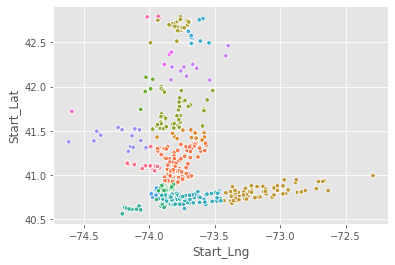

In [91]:
# Map of accidents, color code by county

sns.scatterplot(x='Start_Lng', y='Start_Lat', data=df_state, hue='County', legend=False, s=20)
plt.show()

### Step 7. Deal with categorical data: pd.get_dummies()


In [71]:
# Generate dummies for categorical data
df_state_dummy = pd.get_dummies(df_state,drop_first=True)

# Export data
df_state_dummy.to_csv('./US_Accidents_May19_{}_dummy.csv'.format(state),index=False)

df_state_dummy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 935 entries, 0 to 998
Columns: 290 entries, TMC to Weekday_Wed
dtypes: float64(24), uint8(266)
memory usage: 425.5 KB


### Step 8. Predict the accident severity with various supervised machine learning algorithms

#### Data preparation: train_test_split

In [72]:
# Assign the data
df=df_state_dummy


# Set the target for the prediction
target='Severity'



# Create arrays for the features and the response variable

# set X and y
y = df[target]
X = df.drop(target, axis=1)

In [73]:
y.unique()

array([3., 2.])

In [74]:
y.value_counts()

2.0    505
3.0    430
Name: Severity, dtype: int64

In [75]:
# Split the data set into training and testing data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)

In [76]:
# List of classification algorithms
algo_lst=['Logistic Regression',' K-Nearest Neighbors','Decision Trees','Random Forest']

# Initialize an empty list for the accuracy for each algorithm
accuracy_lst=[]

### Step 9. Predict the accident severity with various supervised machine learning algorithms

   #### Algorithm A. Logistic regression              

In [77]:
# Logistic regression
lr = LogisticRegression(random_state=0)
lr.fit(X_train,y_train)
y_pred=lr.predict(X_test)

# Get the accuracy score
acc=accuracy_score(y_test, y_pred)

# Append to the accuracy list
accuracy_lst.append(acc)

print("[Logistic regression algorithm] accuracy_score: {:.3f}.".format(acc))

[Logistic regression algorithm] accuracy_score: 0.701.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### Step 9. Predict the accident severity with various supervised machine learning algorithms

   #### Algorithm B. The K-Nearest Neighbors (KNN) algorithm
   ##### KNN with 6 neighors

In [78]:
# Create a k-NN classifier with 6 neighbors
knn = KNeighborsClassifier(n_neighbors=6)

# Fit the classifier to the data
knn.fit(X_train,y_train)

# Predict the labels for the training data X
y_pred = knn.predict(X_test)

# Get the accuracy score
acc=accuracy_score(y_test, y_pred)

# Append to the accuracy list
accuracy_lst.append(acc)

print('[K-Nearest Neighbors (KNN)] knn.score: {:.3f}.'.format(knn.score(X_test, y_test)))
print('[K-Nearest Neighbors (KNN)] accuracy_score: {:.3f}.'.format(acc))

[K-Nearest Neighbors (KNN)] knn.score: 0.545.
[K-Nearest Neighbors (KNN)] accuracy_score: 0.545.


### Step 9. Predict the accident severity with various supervised machine learning algorithms

   #### Algorithm B. The K-Nearest Neighbors (KNN) algorithm
   ##### Optmize the number of neighors: plot the accuracy versus number of neighbors

# Skip this cell


# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, n_neighbor in enumerate(neighbors):
    
    # Setup a k-NN Classifier with n_neighbor
    knn = KNeighborsClassifier(n_neighbors=n_neighbor)

    # Fit the classifier to the training data
    knn.fit(X_train,y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()



### Step 9. Predict the accident severity with various supervised machine learning algorithms

   #### Algorithm C. Decision Tree                 

In [79]:
# Decision tree algorithm

# Instantiate dt_entropy, set 'entropy' as the information criterion
dt_entropy = DecisionTreeClassifier(max_depth=8, criterion='entropy', random_state=1)


# Fit dt_entropy to the training set
dt_entropy.fit(X_train, y_train)

# Use dt_entropy to predict test set labels
y_pred= dt_entropy.predict(X_test)

# Evaluate accuracy_entropy
accuracy_entropy = accuracy_score(y_test, y_pred)


# Print accuracy_entropy
print('[Decision Tree -- entropy] accuracy_score: {:.3f}.'.format(accuracy_entropy))



# Instantiate dt_gini, set 'gini' as the information criterion
dt_gini = DecisionTreeClassifier(max_depth=8, criterion='gini', random_state=1)


# Fit dt_entropy to the training set
dt_gini.fit(X_train, y_train)

# Use dt_entropy to predict test set labels
y_pred= dt_gini.predict(X_test)

# Evaluate accuracy_entropy
accuracy_gini = accuracy_score(y_test, y_pred)

# Append to the accuracy list
acc=accuracy_gini
accuracy_lst.append(acc)

# Print accuracy_gini
print('[Decision Tree -- gini] accuracy_score: {:.3f}.'.format(accuracy_gini))

[Decision Tree -- entropy] accuracy_score: 0.754.
[Decision Tree -- gini] accuracy_score: 0.711.


### Step 9. Predict the accident severity with various supervised machine learning algorithms

   #### Algorithm D. Random Forest   
   ##### n_estimators=100                 

In [80]:
# Random Forest algorithm

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)


# Get the accuracy score
acc=accuracy_score(y_test, y_pred)

# Append to the accuracy list
accuracy_lst.append(acc)


# Model Accuracy, how often is the classifier correct?
print("[Randon forest algorithm] accuracy_score: {:.3f}.".format(acc))


[Randon forest algorithm] accuracy_score: 0.791.


### Step 9. Predict the accident severity with various supervised machine learning algorithms

   #### Algorithm D. Random Forest   
   ##### Visualize important features      

No handles with labels found to put in legend.


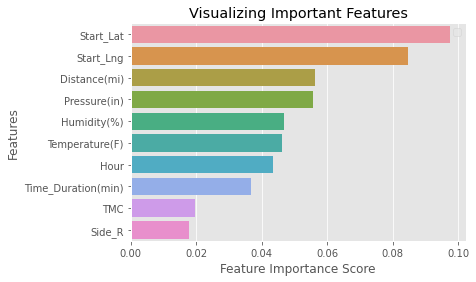

In [81]:
feature_imp = pd.Series(clf.feature_importances_,index=X.columns).sort_values(ascending=False)

# Creating a bar plot, displaying only the top k features
k=10
sns.barplot(x=feature_imp[:10], y=feature_imp.index[:k])
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [82]:
# List top k important features
k=20
feature_imp.sort_values(ascending=False)[:k]

Start_Lat               0.097307
Start_Lng               0.084771
Distance(mi)            0.056137
Pressure(in)            0.055753
Humidity(%)             0.046666
Temperature(F)          0.046025
Hour                    0.043318
Time_Duration(min)      0.036678
TMC                     0.019598
Side_R                  0.017700
County_Dutchess         0.016854
Visibility(mi)          0.014842
County_Suffolk          0.014833
County_Rockland         0.013521
Wind_Direction_West     0.013177
City_Bronx              0.012145
County_Westchester      0.011368
Sunrise_Sunset_Night    0.011049
County_Bronx            0.010043
Traffic_Signal          0.010030
dtype: float64

### Step 9. Predict the accident severity with various supervised machine learning algorithms

   #### Algorithm D. Random Forest   
   ##### Select the top important features, set the threshold      

In [83]:
# Create a selector object that will use the random forest classifier to identify
# features that have an importance of more than 0.03
sfm = SelectFromModel(clf, threshold=0.03)

# Train the selector
sfm.fit(X_train, y_train)

feat_labels=X.columns

# Print the names of the most important features
for feature_list_index in sfm.get_support(indices=True):
    print(feat_labels[feature_list_index])

Start_Lng
Start_Lat
Distance(mi)
Temperature(F)
Humidity(%)
Pressure(in)
Hour
Time_Duration(min)


In [84]:
# Transform the data to create a new dataset containing only the most important features
# Note: We have to apply the transform to both the training X and test X data.
X_important_train = sfm.transform(X_train)
X_important_test = sfm.transform(X_test)

# Create a new random forest classifier for the most important features
clf_important = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)

# Train the new classifier on the new dataset containing the most important features
clf_important.fit(X_important_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [85]:
# Apply The Full Featured Classifier To The Test Data
y_pred = clf.predict(X_test)

# View The Accuracy Of Our Full Feature Model
print('[Randon forest algorithm -- Full feature] accuracy_score: {:.3f}.'.format(accuracy_score(y_test, y_pred)))

# Apply The Full Featured Classifier To The Test Data
y_important_pred = clf_important.predict(X_important_test)

# View The Accuracy Of Our Limited Feature Model
print('[Randon forest algorithm -- Limited feature] accuracy_score: {:.3f}.'.format(accuracy_score(y_test, y_important_pred)))

[Randon forest algorithm -- Full feature] accuracy_score: 0.791.
[Randon forest algorithm -- Limited feature] accuracy_score: 0.727.


### Step 9. Predict the accident severity with various supervised machine learning algorithms

#### Plot the accuracy score versus algorithm

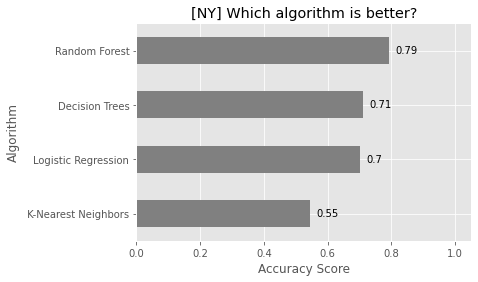

In [86]:
# Make a plot of the accuracy scores for different algorithms

# Generate a list of ticks for y-axis
y_ticks=np.arange(len(algo_lst))

# Combine the list of algorithms and list of accuracy scores into a dataframe, sort the value based on accuracy score
df_acc=pd.DataFrame(list(zip(algo_lst, accuracy_lst)), columns=['Algorithm','Accuracy_Score']).sort_values(by=['Accuracy_Score'],ascending = True)

# Export to a file
df_acc.to_csv('./Accuracy_scores_algorithms_{}.csv'.format(state),index=False)

# Make a plot
ax=df_acc.plot.barh('Algorithm', 'Accuracy_Score', align='center',legend=False,color='0.5')

# Add the data label on to the plot
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+0.02, i.get_y()+0.2, str(round(i.get_width(),2)), fontsize=10)

# Set the limit, lables, ticks and title
plt.xlim(0,1.05)
plt.xlabel('Accuracy Score')
plt.yticks(y_ticks, df_acc['Algorithm'], rotation=0)
plt.title('[{}] Which algorithm is better?'.format(state))

plt.show()

So, As we can observe here, the accuracy score for given dataset using Random Forest yeilds higher score. 

In [116]:
# Define lists of states, colors, linestyles, month order, day_order, and hour_order
state_lst=['NY']
state_lst_full=['New York']
color_lst=['r']
linestyle_lst=['dashed']
month_lst = [ 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul','Aug','Sep','Oct','Nov','Dec']
weekday_lst = [ 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
weekday_lst_full = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
hour_lst= np.arange(24)

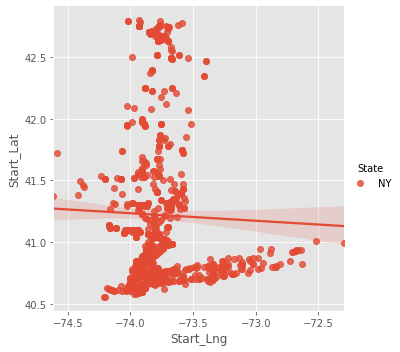

In [117]:
sns.lmplot(x='Start_Lng', y='Start_Lat', data=df, hue='State')
plt.show()

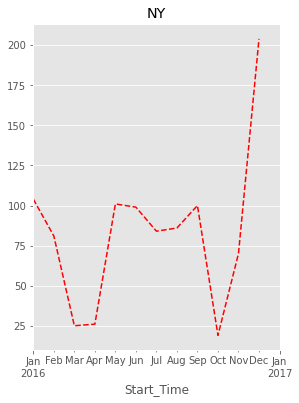

In [110]:

df.set_index('Start_Time',drop=True,inplace=True)


# Set the size of the figure
fig= plt.figure(figsize=(15,6))

# Run a for loop for each state
for i,state in enumerate(state_lst):
    
    # Set a sub plot
    plt.subplot(1, 3, 1+i)
     # Slice the dataframe for the specific state and weekday
    df[df['State']==state].resample('M').count()['ID'].plot(linestyle=linestyle_lst[i], color=color_lst[i])
    
    plt.xlim('2016','2017-Jan')
    
    plt.xlabel=('Year')
    plt.title('{}'.format(state))

plt.show()


df.reset_index(inplace=True)

In [118]:

# Find out how many unique days in the dataset
allday_lst=df.Start_Time.astype(str).str.split(' ')
allday_lst2=[item[0] for item in allday_lst]

print('For New York in this dataset:')
print('There are {} total accidents.'.format(df.shape[0]))
print('There are {} total days.'.format(len(allday_lst2)))
print('There are {} unique days.'.format(len(set(allday_lst2))))
print('On average, there are {} accidents per day.'.format(round(df.shape[0]/len(set(allday_lst2)))))

For New York in this dataset:
There are 999 total accidents.
There are 999 total days.
There are 14 unique days.
On average, there are 71 accidents per day.
